# Part 1: Development of a meta-model to predict monopile damage fraction

Connect google drive to colab.*italicized text*

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Import required packages.

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import keras as keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D, BatchNormalization
from keras import backend as K

print("TensorFlow version:", tf.__version__)
print(keras.__version__)

TensorFlow version: 2.8.0
2.8.0


Load the dataset

In [ ]:
data = pd.read_csv('gdrive/My Drive/FNL_Damage_Hackathon.csv') # correct file location as required


In [ ]:
print(data.shape)
data.head()

(19050, 5)


,Tp,Hs,Uw,Op,D
0,2.0,0.004385,1,1,1.760000e-09
1,2.0,0.004385,1,2,NaN
2,2.0,0.004385,2,1,1.500000e-06
3,2.0,0.004385,2,2,5.710000e-10
4,2.0,0.004385,3,1,1.900000e-07


Remove any NaN values and outliers (threshold not justified here). 




In [ ]:
data = data.dropna() # remove NaN data entries

valid_values = abs(data['D'] < 0.0030) # remove outliers
data = data[valid_values]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16985 entries, 0 to 18999
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Tp      16985 non-null  float64
 1   Hs      16985 non-null  float64
 2   Uw      16985 non-null  int64  
 3   Op      16985 non-null  int64  
 4   D       16985 non-null  float64
dtypes: float64(3), int64(2)
memory usage: 796.2 KB


View imported dataset, which includes the following variables per column

Tp= Peak wave period (s)
Hs = Significant wave height (m)
Uw = Mean wind speed at turbine hub height (m/s)
Op = Turbine opperatinal state, whereby 1 = opperational, and 2 = parked
D = Hourly monopile damage fraction associated with the above variables.

In [ ]:
data.head()

,Tp,Hs,Uw,Op,D
0,2.0,0.004385,1,1,1.760000e-09
2,2.0,0.004385,2,1,1.500000e-06
3,2.0,0.004385,2,2,5.710000e-10
4,2.0,0.004385,3,1,1.900000e-07
5,2.0,0.004385,3,2,4.530000e-10


Select training inputs data, and remove any unwanted columns from inputs dataset.

In [ ]:
y=data[['D']]
x=data.drop(columns=['D'])
x.head()

,Tp,Hs,Uw,Op
0,2.0,0.004385,1,1
2,2.0,0.004385,2,1
3,2.0,0.004385,2,2
4,2.0,0.004385,3,1
5,2.0,0.004385,3,2


Create training and test datasets. Set test:train ratio (80:20 split used in this example)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=42)

Normalise the input data, and reshape for input into convolutional neural
network.

In [ ]:
FNL_output_scaler = MinMaxScaler(feature_range=(0, 1), copy=False) # create scaler
FNL_output_scaler.fit(y_train)
y_train = FNL_output_scaler.transform(y_train)
y_test = FNL_output_scaler.transform(y_test)

FNL_input_scaler = MinMaxScaler(feature_range=(0, 1), copy=False) # create scaler
FNL_input_scaler.fit(x_train)
x_train = FNL_input_scaler.transform(x_train)
x_test = FNL_input_scaler.transform(x_test)

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

Create CNN model

In [ ]:
verbose, epochs, batch_size = 0, 100, 64
		
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=9, padding='same', activation='relu', 
                 input_shape=(x_train.shape[1],x_train.shape[2])))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Conv1D(filters=32, kernel_size=7, padding='same', activation='relu', 
                 input_shape=(x_train.shape[1],x_train.shape[2])))

model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam', 
              metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])
 
model.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4, 64)             640       
                                                                 
 batch_normalization (BatchN  (None, 4, 64)            256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 4, 64)             0         
                                                                 
 conv1d_1 (Conv1D)           (None, 4, 32)             14368     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2, 32)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 64)                0

Train the *model*

In [ ]:
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, 
                    verbose=verbose, validation_data=(x_test, y_test), 
                    shuffle=True)

Predict model results based on test data inputs

In [ ]:
y_test_pred=model.predict(x_test)

print(model.evaluate(x_train,y_train))
print("Test data MSE: %.4f" % mean_squared_error(y_test, y_test_pred))

425/425 [==============================] - 1s 3ms/step - loss: 3.0097e-04 - mean_absolute_percentage_error: 173418.6094
[0.0003009653592016548, 173418.609375]
Test data MSE: 0.0005


Plot results between model predicted damage and simulated damage.

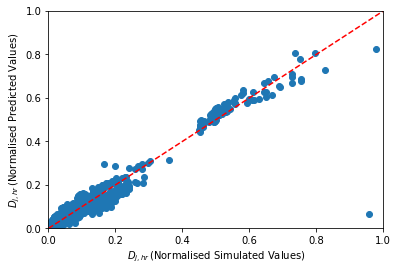

In [ ]:
plt.figure(1)
plt.rcParams["mathtext.default"]
plt.scatter(y_test,y_test_pred) # plot predicted v origonal
plt.xlabel(r'$D_{j,hr} \/$' '(Normalised Simulated Values)')
plt.ylabel(r'$D_{j,hr} \/$' '(Normalised Predicted Values)')
lims = [0, 1]
plt.xlim(lims)
plt.ylim(lims)

xplot = np.linspace(0,1,100)
yplot = xplot
plt.plot(xplot, yplot, '--r')

Plot result residuals, and calculate r-squared score

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


0.9588407268990847

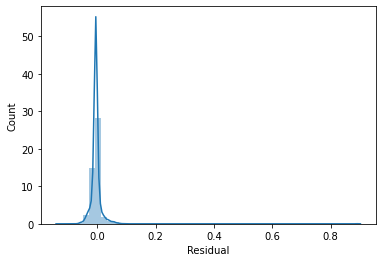

In [ ]:
import seaborn as sns
residuals = y_test - y_test_pred
sns.distplot(residuals)
plt.xlabel(r'Residual')
plt.ylabel(r'Count')

plt.savefig('FNL_cnn_model_residuals_23022022_2.png',dpi=300)

from sklearn.metrics import r2_score
r2_score(y_test, y_test_pred)  

Plot model loss and accuracy

dict_keys(['loss', 'mean_absolute_percentage_error', 'val_loss', 'val_mean_absolute_percentage_error'])


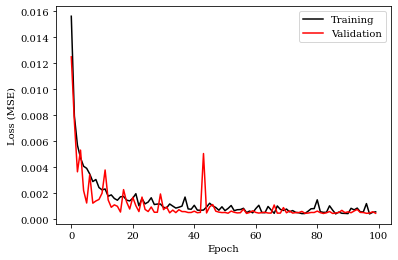

In [ ]:
print(history.history.keys())

from cycler import cycler

plt.figure(1)
plt.rcParams['axes.prop_cycle'] = cycler(color=['k', 'r', 'b', 'g'])
plt.rcParams['font.family'] = 'Serif'

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.savefig('FNL_cnn_loss_23022022_2.png',dpi=300)

plt.show()

save the model

In [ ]:
model.save('FNL_Damage_CNN_model_hackathon')
model.save('FNL_Damage_CNN_model_hackathon.h5')

#from sklearn.externals import joblib
#joblib.dump(FNL_output_scaler, "FNL_output_scaler") 
#joblib.dump(FNL_input_scaler, "FNL_input_scaler") 

INFO:tensorflow:Assets written to: FNL_Damage_CNN_model_hackathon/assets


# Part 2: Calculation of estimated damage from developed meta-model for an example dataset
Now that we have developed a meta-model to estimate monopile damage based on input data, we can input measured data from the North Sea at the FINO1 research platform (www.fino1.de). A data set named "fino1_hourly_aug2019_aug2020.csv" is provide in the root folder, containing hourly input data, and whether the turbine would be parked or operational (a known factor based on the wind speed).

Firstly, import this datasets.

In [ ]:
data_hourly=pd.read_csv('gdrive/My Drive/fino1_hourly_aug2019_aug2020.csv')

Given that the inputs to out model were scaled, we need to apply the same scaling transfer to the measured data we are going to apply to the meta-model. Also, as during model development, we need to reshape the dataset.

In [ ]:
data_hourly=FNL_input_scaler.transform(data_hourly)
data_hourly_input = data_hourly.reshape(data_hourly.shape[0], data_hourly.shape[1], 1)

We can now input our measured dataset into the model to determine the corresponding damage value calculated by the meta-model.

In [ ]:
D_hourly_Pred = model.predict(data_hourly_input)
D_hourly_Pred

array([[0.02153187],
       [0.01892928],
       [0.02101026],
       ...,
       [0.01484532],
       [0.01424222],
       [0.01439073]], dtype=float32)

Given that the output damage values form the meta-model are normalised, we must 

apply the inverse transformation function.


In [ ]:
D_hourly_Pred_true = FNL_output_scaler.inverse_transform(D_hourly_Pred)
D_hourly_Pred_true

array([[6.1257757e-05],
       [5.3853480e-05],
       [5.9773800e-05],
       ...,
       [4.2234726e-05],
       [4.0518917e-05],
       [4.0941432e-05]], dtype=float32)

We now have a series of damage fraction values corresponding to measured conditions, based on the model predicts. 
These values can now be used to estiamte the damage accumulated over the one year period.